<h1>📦 Importing Required Libraries<h1>
<h4>This cell imports all the necessary libraries for implementing a Deep Reinforcement Learning algorithm<h4>

In [1]:
# Import the Gymnasium library for creating reinforcement learning environments
import gymnasium as gym

# Import NumPy for numerical computations and array operations
import numpy as np

# Import PyTorch for building and training deep learning models
import torch
import torch.nn as nn               # For defining neural network layers
import torch.optim as optim         # For optimization algorithms (e.g., Adam)
import torch.nn.functional as F     # For activation functions and loss functions

# Import Python's random module for generating random numbers
import random

# Import Matplotlib for plotting graphs (e.g., rewards over episodes)
import matplotlib.pyplot as plt

# Import tqdm for displaying progress bars in loops
from tqdm import tqdm

# Import ale_py, required to support Atari environments in Gymnasium
import ale_py

# Import deque from collections for implementing the experience replay buffer
from collections import deque

<h1>🎨 Plot Styling Configuration<h1>
<h4>This cell configures the plotting style to improve visualizations throughout training<h4>

In [2]:
# Try to import seaborn for enhanced plot styling
try:
    import seaborn as sns
    seaborn_available = True  # Set flag to True if seaborn is available
except ImportError:
    seaborn_available = False  # Fallback if seaborn is not installed

# Set up plot styling based on availability of seaborn
if seaborn_available:
    # Use seaborn's deep color palette and styling
    sns.set_palette("deep")
    plt.style.use('seaborn-v0_8')  # Updated seaborn style for matplotlib
else:
    # Fallback to 'bmh' style with custom tweaks
    plt.style.use('bmh')  # Clean and readable matplotlib style
    # Define a custom color cycle
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#0072B2', '#D55E00', '#009E73', '#CC79A7'])
    # Update various plot aesthetics for a clean look
    plt.rcParams.update({
        'axes.facecolor': '#F5F5F5',  # Light background for axes
        'axes.edgecolor': '#333333',  # Dark border around axes
        'font.size': 12,              # Default font size
        'grid.linestyle': ':',        # Dotted grid lines
        'grid.alpha': 0.6,            # Grid line transparency
        'figure.facecolor': '#FFFFFF' # White background for the figure
    })


<h1>🕹️ FreewayEnvironment: Environment Wrapper<h1>
<h4>This class wraps the Atari **Freeway-v5** environment using Gymnasium. It provides a clean interface
<h4>

In [3]:
class FreewayEnvironment:
    # Initialize the Freeway Atari environment with RGB visual output
    def __init__(self):
        self.env = gym.make('ALE/Freeway-v5', render_mode='rgb_array')

    # Reset the environment and return the initial observation
    def reset(self):
        state, _ = self.env.reset()  # Ignore the 'info' dictionary
        return state

    # Apply an action and return next state, reward, done flag, and info
    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        return next_state, reward, terminated or truncated, info

<h1>🧰 Utility Functions<h1>
<h4>This section contains helper functions for preprocessing states and visualizing training<h4>

In [4]:
# Convert RGB state to grayscale, normalize values, and flatten it into a 1D tensor
def preprocess_state(state):
    state = np.array(state).mean(axis=2).astype(np.float32) / 255.0
    return torch.FloatTensor(state).flatten().unsqueeze(0)

# Plot training rewards and moving average with custom visual styling
def plot_training_results(rewards, moving_avg, title, moving_avg_window):
    plt.figure(figsize=(12, 6), facecolor='#F8F9FA')
    ax = plt.gca()
    ax.set_facecolor('#E6F0FA')

    plt.plot(rewards, alpha=0.5, label='Episode Reward', color='#005566', linewidth=1.5)
    plt.plot(moving_avg, label=f'Moving Average (window={moving_avg_window})', color='#FF6B35', linewidth=2.5)

    plt.xlabel('Episode', fontsize=10, weight='bold')
    plt.ylabel('Reward', fontsize=10, weight='bold')
    plt.title(title, fontsize=12, weight='bold', pad=15)

    plt.legend(fontsize=12, loc='best', frameon=True, shadow=True, facecolor='#FFFFFF', edgecolor='#333333')
    plt.grid(True, linestyle=':', alpha=0.5, color='#666666')
    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

<h1>🧠 Actor-Critic Neural Network<h1>
<h4>This class defines a simple Actor-Critic model with shared hidden layers and two output heads
<h4>

In [5]:
# Actor-Critic model with shared layers and separate output heads
class ActorCriticNetwork(nn.Module):
    def __init__(self, input_size, action_size, hidden_size=128):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First shared layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second shared layer

        self.actor_head = nn.Linear(hidden_size, action_size)  # Outputs action logits
        self.critic_head = nn.Linear(hidden_size, 1)           # Outputs state value

    # Forward pass returns actor and critic outputs
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.actor_head(x), self.critic_head(x)

<h1>🤖 REINFORCEAgent: Policy Gradient with Baseline<h1>
<h4>This class implements the REINFORCE algorithm with a value function as baseline (Actor-Critic style)
<h4>

In [6]:
# REINFORCE with Baseline Agent
class REINFORCEAgent:
    def __init__(self, state_size, action_size, hidden_size=128, learning_rate=5e-4, discount_factor=0.995):
        # Set device (GPU if available)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Create the actor-critic network
        self.actor_critic = ActorCriticNetwork(state_size, action_size, hidden_size).to(self.device)

        # Set up optimizer and discount factor
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=learning_rate)
        self.discount_factor = discount_factor

        # Storage for training
        self.rewards = []
        self.log_probs = []
        self.state_values = []  # Baseline values from the critic

    # Choose an action based on current policy
    def select_action(self, state):
        state = state.to(self.device)
        logits, value = self.actor_critic(state)
        probs = F.softmax(logits, dim=-1)
        m = torch.distributions.Categorical(probs)
        action = m.sample()

        self.log_probs.append(m.log_prob(action))   # Store log-prob for actor update
        self.state_values.append(value)             # Store value for baseline
        return action.item()

    # Store the received reward
    def store_reward(self, reward):
        self.rewards.append(reward)

    # Update policy and value network using collected episode data
    def update_policy(self):
        R = 0
        returns = deque()

        # Compute discounted returns in reverse
        for r in reversed(self.rewards):
            R = r + self.discount_factor * R
            returns.appendleft(R)
        returns = torch.tensor(list(returns), device=self.device, dtype=torch.float32)

        # Normalize the returns for stability
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        actor_losses = []
        critic_losses = []

        for i in range(len(self.log_probs)):
            log_prob = self.log_probs[i]
            value = self.state_values[i]
            R_t = returns[i]

            advantage = R_t - value.squeeze(-1)  # Remove extra dimension from value
            actor_loss = -log_prob * advantage.detach()  # Policy gradient loss
            critic_loss = F.mse_loss(value, R_t.unsqueeze(0).unsqueeze(0))  # Value loss

            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)

        # Total loss = actor + critic
        loss = torch.stack(actor_losses).sum() + torch.stack(critic_losses).sum()

        # Backpropagation step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Clear memory after update
        self.rewards = []
        self.log_probs = []
        self.state_values = []


<h1>⚡ A2CAgent: Advantage Actor-Critic<h1>
<h4>The `A2CAgent` class implements a lightweight, synchronous variant of Actor-Critic with the following key components
<h4>

In [7]:
# A2C (Advantage Actor-Critic) Agent
class A2CAgent:
    def __init__(self, state_size, action_size, hidden_size=128, learning_rate=5e-4, discount_factor=0.995):
        # Use GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Shared actor-critic network
        self.actor_critic = ActorCriticNetwork(state_size, action_size, hidden_size).to(self.device)

        # Optimizer for training
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=learning_rate)

        # Discount factor for reward propagation
        self.discount_factor = discount_factor

    # Sample action and return info for learning
    def select_action(self, state):
        state = state.to(self.device)
        logits, value = self.actor_critic(state)
        probs = F.softmax(logits, dim=-1)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action), value

    # Update policy and value using one-step TD target
    def update_policy(self, log_prob, value, reward, next_state_value, done):
        # Compute TD target: r + γV(s')
        target_value = reward + self.discount_factor * next_state_value * (1 - int(done))

        # Compute advantage (TD error)
        advantage = target_value.detach() - value

        # Actor loss encourages actions with positive advantage
        actor_loss = -log_prob * advantage.squeeze(-1)

        # Critic loss minimizes prediction error on value
        critic_loss = F.mse_loss(value, target_value)

        # Combine losses and apply gradient step
        loss = actor_loss + critic_loss

        self.optimizer.zero_grad()
        loss.backward()

        # Gradient clipping for stability
        for param in self.actor_critic.parameters():
            if param.grad is not None:
                param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

<h1>🎮 Training Function<h1>
<h4>This function runs the full training loop for a reinforcement learning agent, with tracking of performance
<h4>


In [8]:
# Training Loop for REINFORCE or A2C
def train_agent(environment, agent, num_episodes=1000, max_steps_per_episode=1000, moving_avg_window=150):
    episode_rewards = []
    moving_averages = []

    for episode in tqdm(range(num_episodes), desc="Training Progress"):
        state = preprocess_state(environment.reset())
        total_reward = 0

        # Clear stored data for REINFORCE agent
        if isinstance(agent, REINFORCEAgent):
            agent.rewards = []
            agent.log_probs = []
            agent.state_values = []

        for step in range(max_steps_per_episode):
            if isinstance(agent, REINFORCEAgent):
                # Select action and store reward
                action = agent.select_action(state)
                next_state, reward, done, _ = environment.step(action)
                agent.store_reward(reward)

            elif isinstance(agent, A2CAgent):
                # Select action and get log prob and value
                action, log_prob, value = agent.select_action(state)
                next_state, reward, done, _ = environment.step(action)

                # Prepare next state value (0 if episode ended)
                next_state_tensor = preprocess_state(next_state) if not done else None
                with torch.no_grad():
                    if next_state_tensor is not None:
                        _, next_state_value = agent.actor_critic(next_state_tensor.to(agent.device))
                    else:
                        next_state_value = torch.tensor(0.0).to(agent.device).unsqueeze(0).unsqueeze(0)

                # Update policy using A2C logic
                agent.update_policy(log_prob, value, reward, next_state_value, done)

            # Update current state (reset if done)
            state = preprocess_state(next_state) if not done else preprocess_state(environment.reset())
            total_reward += reward

            if done:
                break

        # Update policy at episode end for REINFORCE
        if isinstance(agent, REINFORCEAgent):
            agent.update_policy()

        # Log reward and compute moving average
        episode_rewards.append(total_reward)
        avg = np.mean(episode_rewards[-moving_avg_window:]) if episode >= moving_avg_window - 1 else np.mean(episode_rewards)
        moving_averages.append(avg)

    return episode_rewards, moving_averages

<h1>🧪 Policy Evaluation<h1>
<h4>This function evaluates the agent's performance by running it over multiple episodes<h4>

In [9]:
# Policy Evaluation
def evaluate_policy(environment, agent, num_eval_episodes=100):
    # Run the trained policy for multiple episodes and track performance
    eval_rewards = []

    for _ in tqdm(range(num_eval_episodes), desc="Evaluating Policy"):
        state = preprocess_state(environment.reset())  # Reset environment and preprocess state
        total_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                # Choose the most probable (greedy) action based on current policy
                if isinstance(agent, REINFORCEAgent) or isinstance(agent, A2CAgent):
                    logits, _ = agent.actor_critic(state.to(agent.device))
                    probs = F.softmax(logits, dim=-1)
                    action = torch.argmax(probs).item()
                else:
                    action = agent.select_action(state).item()  # For possible DQN-based agents later

            next_state, reward, done, _ = environment.step(action)  # Apply action and receive feedback
            state = preprocess_state(next_state)  # Prepare next state
            total_reward += reward  # Accumulate episode reward

        eval_rewards.append(total_reward)  # Save total reward for this episode

    mean_reward = np.mean(eval_rewards)  # Average reward over all episodes
    std_reward = np.std(eval_rewards)    # Standard deviation to measure variability
    return mean_reward, std_reward

<h1>🚀 Main Experiment: REINFORCE vs A2C on Freeway<h1>
<h4>This section runs the full training and evaluation for both<h4>

--------------------------------------------------
           Training REINFORCE with Baseline
--------------------------------------------------


Training Progress: 100%|██████████| 1000/1000 [1:10:31<00:00,  4.23s/it]


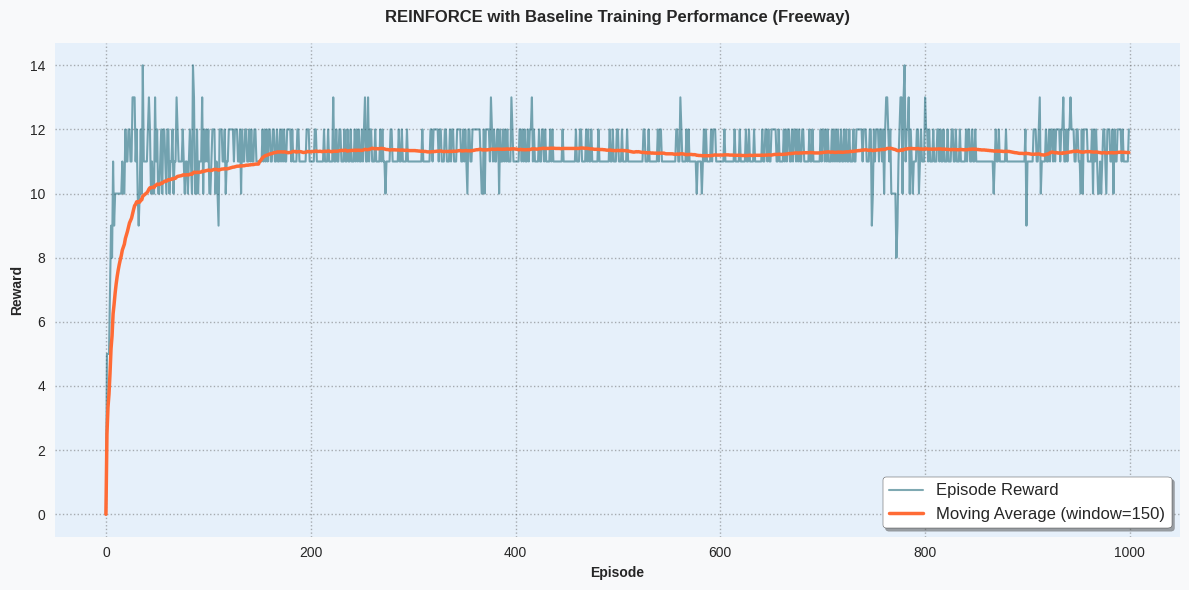


--------------------------------------------------
           Evaluating REINFORCE Policy
--------------------------------------------------


Evaluating Policy: 100%|██████████| 100/100 [08:40<00:00,  5.21s/it]


REINFORCE with Baseline - Mean Reward over 100 episodes: 21.52, Std: 0.94

--------------------------------------------------
           Training A2C
--------------------------------------------------


Training Progress: 100%|██████████| 1000/1000 [1:52:37<00:00,  6.76s/it]


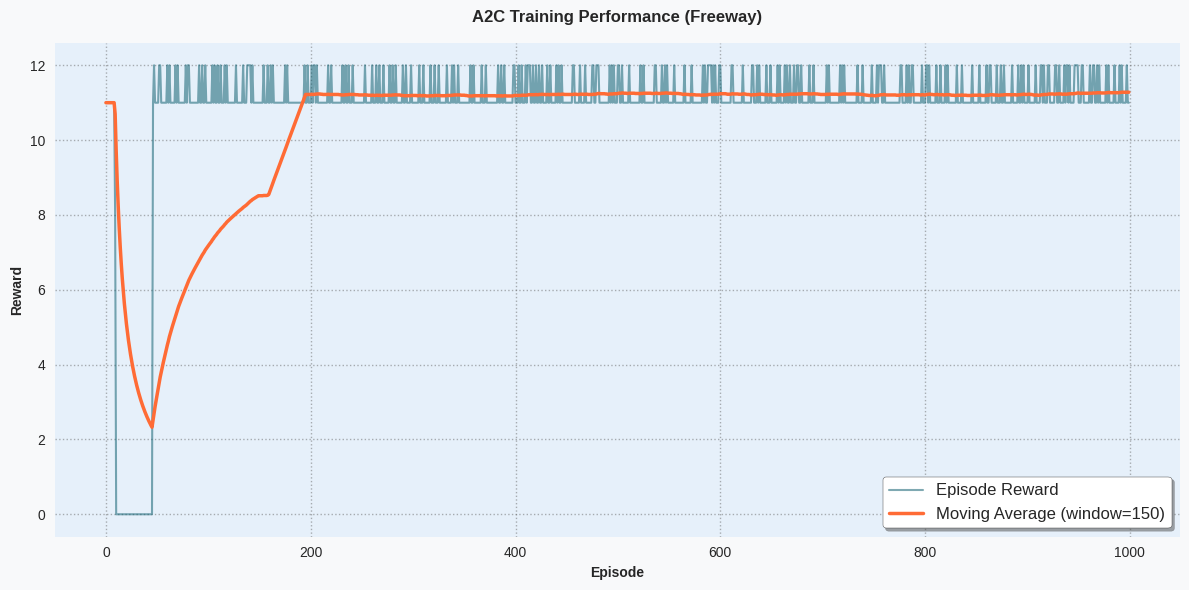


--------------------------------------------------
           Evaluating A2C Policy
--------------------------------------------------


Evaluating Policy: 100%|██████████| 100/100 [08:36<00:00,  5.16s/it]

A2C - Mean Reward over 100 episodes: 21.45, Std: 0.85

--------------------------------------------------
           Comparison and Analysis
--------------------------------------------------
REINFORCE with Baseline:
  - Mean Reward: 21.52, Standard Deviation: 0.94
A2C:
  - Mean Reward: 21.45, Standard Deviation: 0.85


In [11]:
# Main Experiment Execution
if __name__ == '__main__':
    # Initialize environment and determine input/output sizes
    env = FreewayEnvironment()
    sample_state = preprocess_state(env.env.observation_space.sample())
    state_size = sample_state.shape[1]
    action_size = env.env.action_space.n

    # Shared hyperparameters for both agents
    COMMON_HYPERPARAMS = {
        'hidden_size': 128,
        'learning_rate': 5e-4,
        'discount_factor': 0.995,
    }

    NUM_EPISODES = 1000
    MAX_STEPS_PER_EPISODE = 1000
    MOVING_AVG_WINDOW = 150
    NUM_EVAL_EPISODES = 100

    print("--------------------------------------------------")
    print("           Training REINFORCE with Baseline")
    print("--------------------------------------------------")
    reinforce_agent = REINFORCEAgent(state_size, action_size, **COMMON_HYPERPARAMS)
    reinforce_rewards, reinforce_moving_avg = train_agent(
        env, reinforce_agent,
        num_episodes=NUM_EPISODES,
        max_steps_per_episode=MAX_STEPS_PER_EPISODE,
        moving_avg_window=MOVING_AVG_WINDOW
    )
    plot_training_results(
        reinforce_rewards,
        reinforce_moving_avg,
        'REINFORCE with Baseline Training Performance (Freeway)',
        MOVING_AVG_WINDOW
    )

    print("\n--------------------------------------------------")
    print("           Evaluating REINFORCE Policy")
    print("--------------------------------------------------")
    reinforce_mean_reward, reinforce_std_reward = evaluate_policy(env, reinforce_agent, NUM_EVAL_EPISODES)
    print(f"REINFORCE with Baseline - Mean Reward over {NUM_EVAL_EPISODES} episodes: {reinforce_mean_reward:.2f}, Std: {reinforce_std_reward:.2f}")

    print("\n--------------------------------------------------")
    print("           Training A2C")
    print("--------------------------------------------------")
    a2c_agent = A2CAgent(state_size, action_size, **COMMON_HYPERPARAMS)
    a2c_rewards, a2c_moving_avg = train_agent(
        env, a2c_agent,
        num_episodes=NUM_EPISODES,
        max_steps_per_episode=MAX_STEPS_PER_EPISODE,
        moving_avg_window=MOVING_AVG_WINDOW
    )
    plot_training_results(
        a2c_rewards,
        a2c_moving_avg,
        'A2C Training Performance (Freeway)',
        MOVING_AVG_WINDOW
    )

    print("\n--------------------------------------------------")
    print("           Evaluating A2C Policy")
    print("--------------------------------------------------")
    a2c_mean_reward, a2c_std_reward = evaluate_policy(env, a2c_agent, NUM_EVAL_EPISODES)
    print(f"A2C - Mean Reward over {NUM_EVAL_EPISODES} episodes: {a2c_mean_reward:.2f}, Std: {a2c_std_reward:.2f}")

    print("\n--------------------------------------------------")
    print("           Comparison and Analysis")
    print("--------------------------------------------------")
    print("REINFORCE with Baseline:")
    print(f"  - Mean Reward: {reinforce_mean_reward:.2f}, Standard Deviation: {reinforce_std_reward:.2f}")
    print("A2C:")
    print(f"  - Mean Reward: {a2c_mean_reward:.2f}, Standard Deviation: {a2c_std_reward:.2f}")